In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

### data ingestion

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/entbappy/Branching-tutorial/refs/heads/master/tweet_emotions.csv')

df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [5]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [8]:
df.drop(columns='tweet_id',inplace=True)

In [9]:
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [10]:
df.sentiment.value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [13]:
%%capture
!pip install matplotlib

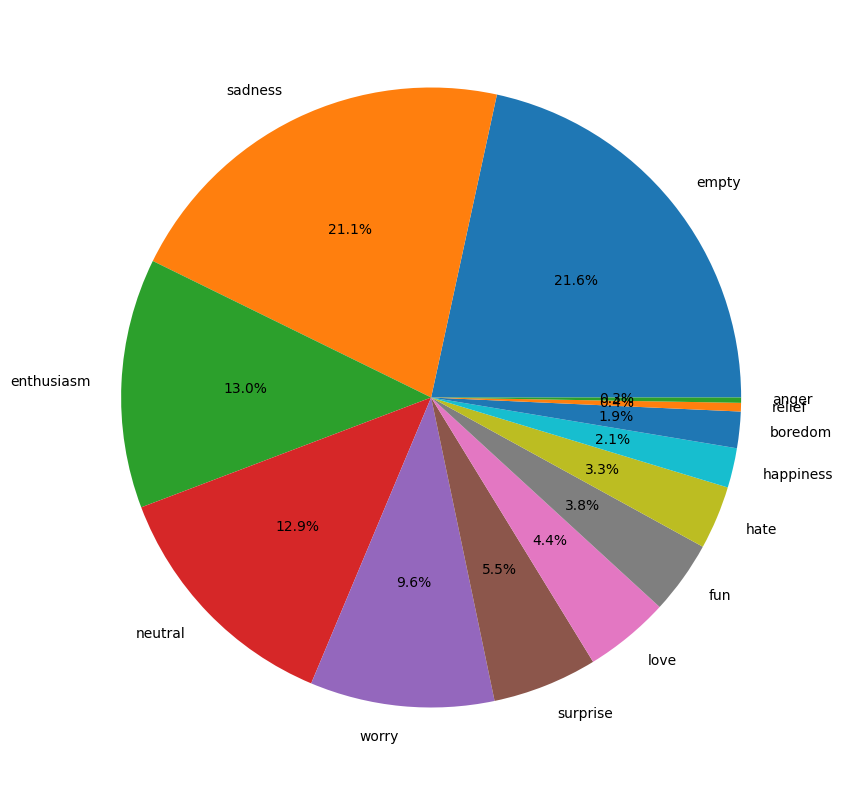

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
plt.pie(df.sentiment.value_counts(),autopct='%1.1f%%',labels=df.sentiment.unique(),)
plt.show()

In [26]:
df.sample(5)

,sentiment,content
13588,sadness,@mitchelmusso Im sad i cant go. it makes me sad
24884,neutral,@geirfreysson my dad just bought me both of th...
5935,empty,@hellorachael yep
34823,love,Happy mothers day to all the mommies
32591,love,@jusreenomas i didnt think the vid was hoeish ...


In [27]:
df.shape

(40000, 2)

In [43]:
final_df = df[df['sentiment'].isin(['happiness','sadness'])]

In [45]:
final_df.sample(5)

,sentiment,content
27008,happiness,@lilazngangsta have a awesome day at school!!!
7995,happiness,@PhreshlyPhaded Oh wow Thanks for the info.
767,sadness,wow I feel like ish and I really feel bad bec...
34493,happiness,Yay my friend Glen is here. Now i'm like this
17101,sadness,@Jtay1995 It's finally summer! Unforunately I ...


In [36]:
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
sentiment_replace = lambda x: 1 if x=='happiness' else 0

In [59]:
final_df['sentiment']=final_df['sentiment'].apply(sentiment_replace)

C:\Users\Admin\AppData\Local\Temp\ipykernel_33688\633565379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['sentiment']=final_df['sentiment'].apply(sentiment_replace)


In [62]:
final_df.head

<bound method NDFrame.head of        sentiment                                            content
1              0  Layin n bed with a headache  ughhhh...waitin o...
2              0                Funeral ceremony...gloomy friday...
6              0  I should be sleep, but im not! thinking about ...
8              0            @charviray Charlene my love. I miss you
9              0         @kelcouch I'm sorry  at least it's Friday?
...          ...                                                ...
39986          1  going to watch boy in the striped pj's hope i ...
39987          1  gave the bikes a thorough wash, degrease it an...
39988          1  had SUCH and AMAZING time last night, McFly we...
39994          1                      Succesfully following Tayla!!
39998          1  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...

[10374 rows x 2 columns]>

In [96]:
train_data,test_data = train_test_split(final_df,test_size=0.2,random_state=42)


### Data Preprocessing

In [97]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()

    text = text.split()
    text = [lemmatizer.lemmatize(y) for y in text]

    return " ".join(text)

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    Text = [i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def removing_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text
def lower_case(text):
    text = text.split()
    text = [y.lower() for y in text]
    return " ".join(text)

def removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.content = df.content.apply(lambda content: lower_case(content))
    df.content = df.content.apply(lambda content: remove_stop_words(content))
    df.content = df.content.apply(lambda content: removing_numbers(content))
    df.content = df.content.apply(lambda content: removing_punctuations(content))
    df.content = df.content.apply(lambda content: removing_urls(content))
    df.content = df.content.apply(lambda content: lemmatization(content))


def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= removing_numbers(sentence)
    sentence= removing_punctuations(sentence)
    sentence= removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
normalized_sentence("That's it? It's done already? This is one")


'that s it done already one'

In [100]:
train_data = normalize_text(train_data)
test_data = normalize_text(test_data)

In [101]:
test_data

,sentiment,content
11535,0,look like rained weekend climbing
32287,0,hi everyone miss much muahhhhhhhhhhhhhhhhhhhhh...
17534,0,rode moped mall fun stuff flippin gorgeous out...
4696,0,gutted vodafone wont repair faulty samsung omn...
23706,1,shadowowns aww lt thank youu
...,...,...
38000,1,russellburnham nice one
1540,0,tired climb bed fall asleep hope weekend fun c...
38031,1,jadeyyg http twitpic com wrxq whens little gin...
14702,0,leirastorm that s sucky miss on


### Feature Engineering

In [102]:
X_train = train_data['content'].values
y_train = train_data['sentiment'].values
X_test = test_data['content'].values
y_test = test_data['sentiment'].values

In [103]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [104]:
train_df = pd.DataFrame(X_train_bow.toarray())
train_df['label'] = y_train
train_df

,0,1,2,3,4,5,6,7,8,9,...,14223,14224,14225,14226,14227,14228,14229,14230,14231,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Building

In [105]:
from sklearn.metrics import classification_report

In [106]:
xgb_model = xgb.XGBClassifier(use_label_encoder = True, eval_metric = 'mlogloss')
xgb_model.fit(X_train_bow,y_train)
y_pred = xgb_model.predict(X_test_bow)

accuracy = accuracy_score(y_test,y_pred)
classification_rep = classification_report(y_test,y_pred)
print('Accuracy:',accuracy)
print('classification report:\n',classification_rep)

e:\MLOPOS\DVC-RUN\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:28:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.771566265060241
classification report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79      1060
           1       0.80      0.71      0.75      1015

    accuracy                           0.77      2075
   macro avg       0.77      0.77      0.77      2075
weighted avg       0.77      0.77      0.77      2075



### Model evaluation

In [107]:
y_pred = xgb_model.predict(X_test_bow)
y_pred_proba = xgb_model.predict_proba(X_test_bow)[:,1]

precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred_proba)

In [108]:
print(f"Precision: {precision}")
print(f'Recall: {recall}')
print(f'AUC {auc}')

Precision: 0.7988950276243094
Recall: 0.7123152709359606
AUC 0.8595775629705363
